In [1]:
import soundfile as sf
import librosa
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from tqdm import tqdm
import pandas as pd


## Функция для получения фич

In [2]:
def extract_features(path, target_sr=16000, n_mfcc=13):
    y, sr = sf.read(path)

    if y.ndim > 1:
        y = y.mean(axis=1)

    if sr != target_sr:
        y = librosa.resample(y, orig_sr=sr, target_sr=target_sr)
        sr = target_sr

    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    delta = librosa.feature.delta(mfcc)
    delta2 = librosa.feature.delta(mfcc, order=2)

    feats = np.vstack([mfcc, delta, delta2])

    return np.hstack([
        feats.mean(axis=1),
        feats.std(axis=1)
    ])


Пробовали и другие фичи: разные спектральные характеристики (centroid / bandwidth / rolloff / contrast), pitch, ZCR, voicing и тд. Но к увеличению качества это не привело.

## Функция для отображения Confusion Matrix

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def show_confusion_matrix(y_true, y_pred, classes, title="Матрица ошибок"):
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(10, 8))
    
    sns.heatmap(
        cm, 
        annot=True,        
        fmt='d',          
        xticklabels=classes, 
        yticklabels=classes, 
        cmap='Blues'        
    )
    
    plt.ylabel('На самом деле (True)')
    plt.xlabel('Предсказано (Predicted)')
    plt.title(title)
    plt.show()

## Функция для отображения метрик

In [4]:
def show_simple_report(y_true, y_pred, target_names):
    report_dict = classification_report(
        y_true, 
        y_pred, 
        target_names=target_names, 
        output_dict=True
    )
    
    df_report = pd.DataFrame(report_dict).transpose()
    
    return df_report.style.format({
        'precision': '{:.3f}',  
        'recall':    '{:.3f}',
        'f1-score':  '{:.3f}',
        'support':   '{:.0f}'  
    })

## Подготовка данных

Ограничим количество файлов, так как использовать все будет слишком накладно и не оправдано.

In [5]:
import random


FILES_PER_LANG = 10000
RANDOM_SEED = 42

random.seed(RANDOM_SEED)


In [6]:
DATA_DIR = "/kaggle/input/voxlingua107"

LANGS = ["ru", "en", "es", "fr", "de"]

label_map = {
    "ru": 0,
    "en": 1,
    "es": 2,
    "fr": 3,
    "de": 4,
}

X = []
y = []


for lang in LANGS:
    lang_dir = os.path.join(DATA_DIR, f"{lang}/{lang}")

    files = [
        f for f in os.listdir(lang_dir)
        if f.endswith(".wav")
    ]

    random.shuffle(files)
    files = files[:FILES_PER_LANG]

    print(f"{lang}: используем {len(files)} файлов")

    for fname in tqdm(files):
        path = os.path.join(lang_dir, fname)
        try:
            feats = extract_features(path)
            X.append(feats)
            y.append(label_map[lang])
        except Exception as e:
            print(f"Ошибка в {path}: {e}")

X = np.array(X)
y = np.array(y)

print("Итоговый датасет:")
print("X shape:", X.shape)
print("y shape:", y.shape)


ru: используем 10000 файлов


100%|██████████| 10000/10000 [05:08<00:00, 32.43it/s]


en: используем 10000 файлов


100%|██████████| 10000/10000 [04:54<00:00, 33.92it/s]


es: используем 10000 файлов


100%|██████████| 10000/10000 [04:50<00:00, 34.42it/s]


fr: используем 10000 файлов


100%|██████████| 10000/10000 [04:40<00:00, 35.69it/s]


de: используем 10000 файлов


100%|██████████| 10000/10000 [04:53<00:00, 34.09it/s]


Итоговый датасет:
X shape: (50000, 78)
y shape: (50000,)


In [7]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


## Пробуем разные модели классификации

In [8]:
log_reg = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(
        max_iter=10000,
        class_weight="balanced"
    ))
])

log_reg.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 LogisticRegression(class_weight='balanced', max_iter=10000))])

In [9]:
y_train_pred = log_reg.predict(X_train)

print("TRAIN")
print("Accuracy:", accuracy_score(y_train, y_train_pred))
df_result_train = show_simple_report(y_train, y_train_pred, LANGS)

df_result_train

TRAIN
Accuracy: 0.513525


,precision,recall,f1-score,support
ru,0.492,0.468,0.480,8000
en,0.531,0.524,0.528,8000
es,0.562,0.616,0.588,8000
fr,0.483,0.472,0.477,8000
de,0.494,0.487,0.490,8000
accuracy,0.514,0.514,0.514,1
macro avg,0.512,0.514,0.513,40000
weighted avg,0.512,0.514,0.513,40000


In [10]:
# val
y_val_pred = log_reg.predict(X_val)

print("\nVALIDATION")
print("Accuracy:", accuracy_score(y_val, y_val_pred))
df_result_val = show_simple_report(y_val, y_val_pred, LANGS)
df_result_val


VALIDATION
Accuracy: 0.5132


,precision,recall,f1-score,support
ru,0.488,0.478,0.483,2000
en,0.527,0.515,0.521,2000
es,0.574,0.609,0.591,2000
fr,0.486,0.489,0.488,2000
de,0.486,0.474,0.480,2000
accuracy,0.513,0.513,0.513,1
macro avg,0.512,0.513,0.513,10000
weighted avg,0.512,0.513,0.513,10000


## Посмотрим на Confusion Matrix на валидации

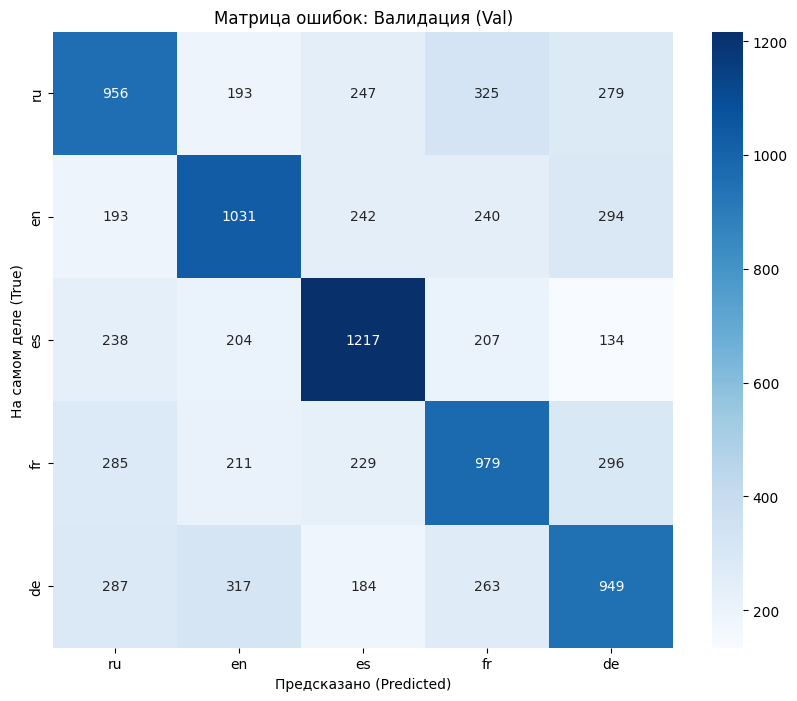

In [11]:
show_confusion_matrix(
    y_val, 
    y_val_pred, 
    classes=LANGS, 
    title="Матрица ошибок: Валидация (Val)"
)

In [12]:
from sklearn.svm import SVC

rbf_svm = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", SVC(
        kernel="rbf",
        C=8,
        gamma="scale",
        class_weight="balanced"
    ))
])

rbf_svm.fit(X_train, y_train)


Pipeline(steps=[('scaler', StandardScaler()),
                ('clf', SVC(C=8, class_weight='balanced'))])

In [13]:
y_train_pred = rbf_svm.predict(X_train)

print("TRAIN")
print("Accuracy:", accuracy_score(y_train, y_train_pred))
df_result_train = show_simple_report(y_train, y_train_pred, LANGS)

df_result_train


TRAIN
Accuracy: 0.949475


,precision,recall,f1-score,support
ru,0.938,0.948,0.943,8000
en,0.957,0.945,0.951,8000
es,0.952,0.968,0.960,8000
fr,0.963,0.946,0.954,8000
de,0.938,0.941,0.939,8000
accuracy,0.949,0.949,0.949,1
macro avg,0.950,0.949,0.949,40000
weighted avg,0.950,0.949,0.949,40000


In [14]:
# val
y_val_pred = rbf_svm.predict(X_val)

print("\nVALIDATION")
print("Accuracy:", accuracy_score(y_val, y_val_pred))
df_result_val = show_simple_report(y_val, y_val_pred, LANGS)
df_result_val


VALIDATION
Accuracy: 0.7248


,precision,recall,f1-score,support
ru,0.691,0.732,0.711,2000
en,0.723,0.719,0.721,2000
es,0.776,0.779,0.777,2000
fr,0.698,0.721,0.709,2000
de,0.740,0.674,0.705,2000
accuracy,0.725,0.725,0.725,1
macro avg,0.726,0.725,0.725,10000
weighted avg,0.726,0.725,0.725,10000


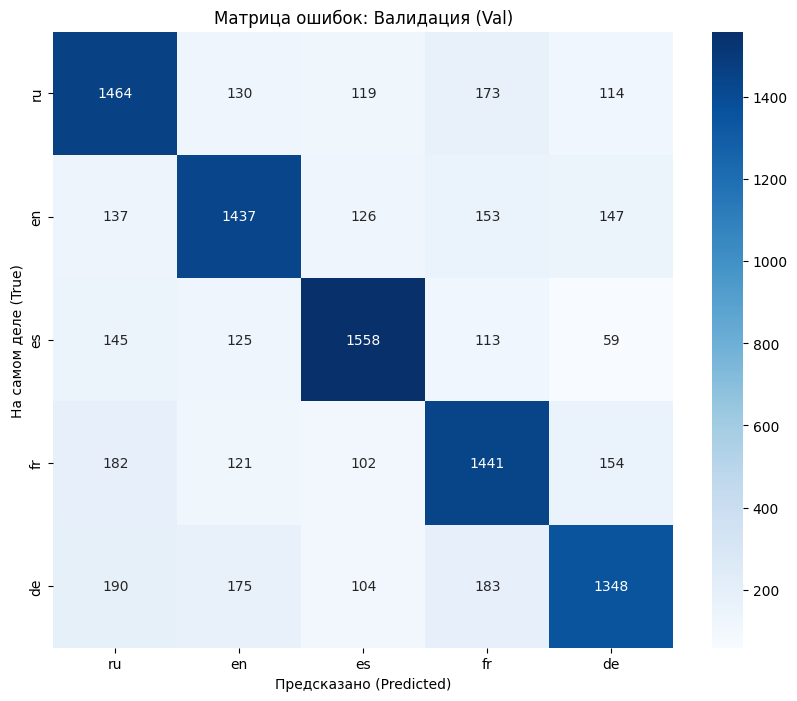

In [15]:
show_confusion_matrix(
    y_val, 
    y_val_pred, 
    classes=LANGS, 
    title="Матрица ошибок: Валидация (Val)"
)

In [16]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    min_samples_leaf=2,
    class_weight="balanced",
    n_jobs=-1,
    random_state=42
)

rf.fit(X_train, y_train)


RandomForestClassifier(class_weight='balanced', min_samples_leaf=2,
                       n_estimators=300, n_jobs=-1, random_state=42)

In [17]:
y_train_pred = rf.predict(X_train)

print("TRAIN")
print("Accuracy:", accuracy_score(y_train, y_train_pred))
df_result_train = show_simple_report(y_train, y_train_pred, LANGS)

df_result_train


TRAIN
Accuracy: 1.0


,precision,recall,f1-score,support
ru,1.000,1.000,1.000,8000
en,1.000,1.000,1.000,8000
es,1.000,1.000,1.000,8000
fr,1.000,1.000,1.000,8000
de,1.000,1.000,1.000,8000
accuracy,1.000,1.000,1.000,1
macro avg,1.000,1.000,1.000,40000
weighted avg,1.000,1.000,1.000,40000


In [18]:
# val
y_val_pred = rf.predict(X_val)

print("\nVALIDATION")
print("Accuracy:", accuracy_score(y_val, y_val_pred))
df_result_val = show_simple_report(y_val, y_val_pred, LANGS)
df_result_val


VALIDATION
Accuracy: 0.667


,precision,recall,f1-score,support
ru,0.691,0.657,0.674,2000
en,0.671,0.627,0.648,2000
es,0.666,0.781,0.719,2000
fr,0.628,0.643,0.636,2000
de,0.682,0.626,0.653,2000
accuracy,0.667,0.667,0.667,1
macro avg,0.668,0.667,0.666,10000
weighted avg,0.668,0.667,0.666,10000


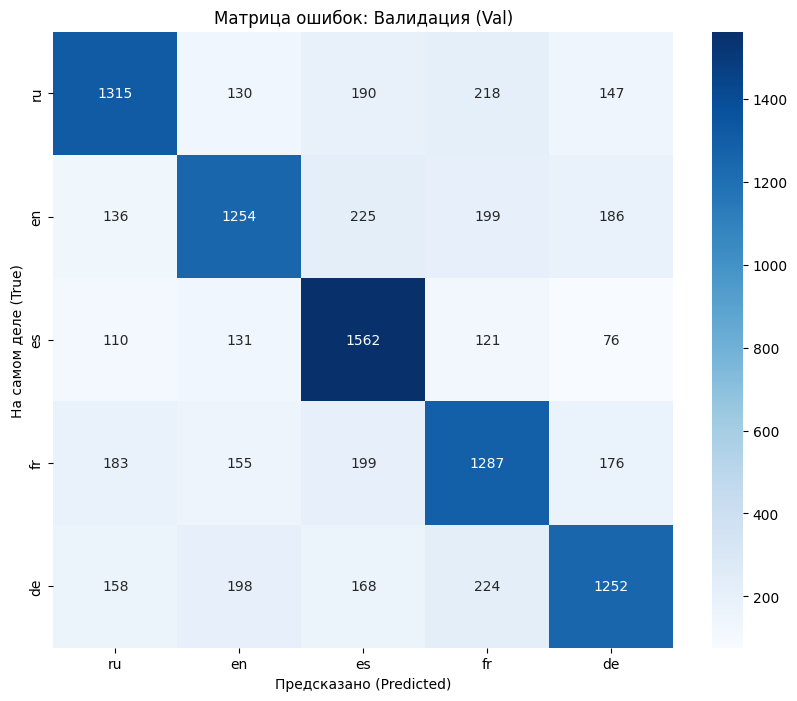

In [19]:
show_confusion_matrix(
    y_val, 
    y_val_pred, 
    classes=LANGS, 
    title="Матрица ошибок: Валидация (Val)"
)

In [20]:
from sklearn.ensemble import HistGradientBoostingClassifier

hgb = HistGradientBoostingClassifier(
    max_depth=10,
    learning_rate=0.05,
    max_iter=300,
    l2_regularization=0.,
    random_state=42
)

hgb.fit(X_train, y_train)


HistGradientBoostingClassifier(learning_rate=0.05, max_depth=10, max_iter=300,
                               random_state=42)

In [21]:
y_train_pred = hgb.predict(X_train)

print("TRAIN")
print("Accuracy:", accuracy_score(y_train, y_train_pred))
df_result_train = show_simple_report(y_train, y_train_pred, LANGS)

df_result_train

TRAIN
Accuracy: 0.897725


,precision,recall,f1-score,support
ru,0.903,0.882,0.893,8000
en,0.919,0.888,0.903,8000
es,0.894,0.933,0.913,8000
fr,0.889,0.896,0.893,8000
de,0.884,0.889,0.887,8000
accuracy,0.898,0.898,0.898,1
macro avg,0.898,0.898,0.898,40000
weighted avg,0.898,0.898,0.898,40000


In [22]:
# val
y_val_pred = hgb.predict(X_val)

print("\nVALIDATION")
print("Accuracy:", accuracy_score(y_val, y_val_pred))
df_result_val = show_simple_report(y_val, y_val_pred, LANGS)
df_result_val


VALIDATION
Accuracy: 0.7095


,precision,recall,f1-score,support
ru,0.699,0.693,0.696,2000
en,0.725,0.691,0.707,2000
es,0.751,0.791,0.770,2000
fr,0.675,0.709,0.692,2000
de,0.697,0.664,0.680,2000
accuracy,0.710,0.710,0.710,1
macro avg,0.709,0.710,0.709,10000
weighted avg,0.709,0.710,0.709,10000


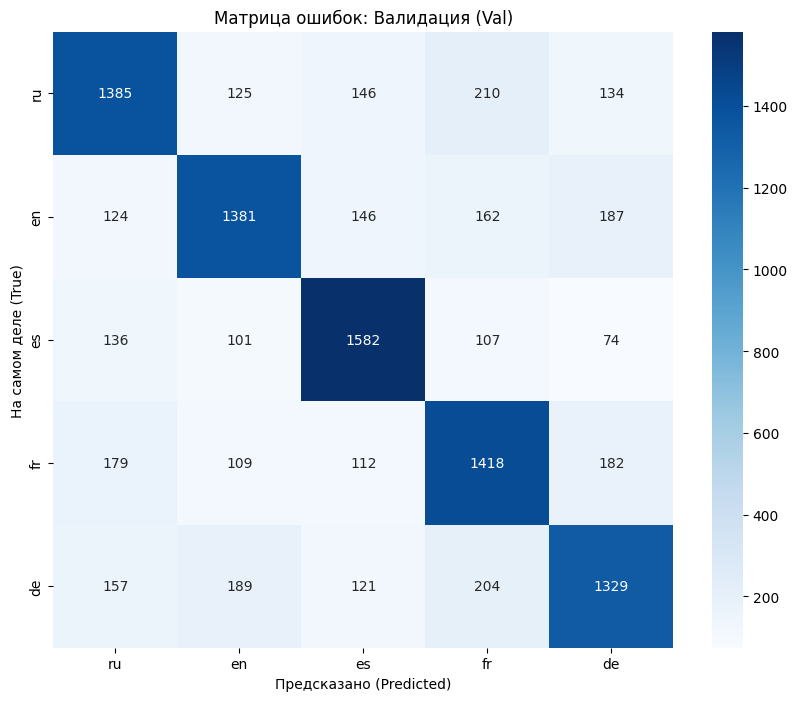

In [23]:
show_confusion_matrix(
    y_val, 
    y_val_pred, 
    classes=LANGS, 
    title="Матрица ошибок: Валидация (Val)"
)

In [24]:
from joblib import dump

dump(log_reg, "log_reg_clf.joblib")
dump(rbf_svm, "rbf_svm_clf.joblib")
dump(rf, "rf_clf.joblib")
dump(hgb, "hgb_clf.joblib")

['hgb_clf.joblib']